# Discussion HW 1
## FINM 25000-2024
### Mark Hendricks

**This is NOT the solution to HW 1.** Rather, it is a notebook used to discuss the homework in class. Thus, it may differ from HW 1 in small ways, and it is not the recommended way to code HW 1.**

**If looking for a solution to emulate, see the `solutions` subfolder in the github repo.**

## Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Data

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [3]:
info

,ETF Description
Symbol,
SPY,Domestic Equity SPDR S&P500
EFA,Foreign Equity iShares EAFE
EEM,iShares Emerging Markets
PSP,Private Equity Invesco Global Private Equity
QAI,Absolute Return IQ Multi-Strat
HYG,High Yield iShares High Yield Corporate Bond
DBC,Invesco DB Commodity Index Tracking Fund
IYR,Real Estate iShares US Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury


In [4]:
retsx

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0988,0.1146,0.1550,0.2296,0.0223,0.1379,-0.0016,0.2956,-0.0280,0.0084,-0.0185
2009-05-31,0.0589,0.1324,0.1599,0.0544,0.0283,0.0290,0.1631,0.0232,-0.0203,0.0541,0.0204
2009-06-30,-0.0013,-0.0146,-0.0231,0.0448,-0.0040,0.0329,-0.0269,-0.0255,-0.0062,0.0046,0.0014
2009-07-31,0.0746,0.1004,0.1102,0.1433,0.0154,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0365,0.0446,-0.0136,0.0330,-0.0046,-0.0174,-0.0408,0.1315,0.0072,0.0072,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31,0.0119,-0.0085,-0.0493,-0.0103,-0.0080,-0.0028,0.0092,-0.0550,-0.0033,-0.0346,-0.0006
2024-02-29,0.0483,0.0259,0.0377,0.0380,0.0117,-0.0009,-0.0192,0.0174,-0.0248,-0.0147,-0.0144
2024-03-31,0.0285,0.0296,0.0231,0.0286,0.0103,0.0067,0.0404,0.0144,0.0032,-0.0003,0.0023


# Functions that will be useful
## Basic performance metrics

In [5]:
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

## Tangency portfolio

In [6]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

# Section 2 - Required Analysis
## 2.1

In [7]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1451,0.1479,0.9814,-0.1290,0.1268
HYG,0.0629,0.0883,0.7125,-0.1044,0.1379
IYR,0.1227,0.1898,0.6467,-0.2005,0.2956
PSP,0.1344,0.2270,0.5920,-0.2789,0.2296
EFA,0.0838,0.1648,0.5085,-0.1452,0.1429
TIP,0.0202,0.0518,0.3910,-0.0676,0.0422
QAI,0.0194,0.0509,0.3803,-0.0605,0.0364
EEM,0.0650,0.1942,0.3345,-0.1791,0.1628
IEF,0.0112,0.0643,0.1750,-0.0476,0.0461
DBC,0.0219,0.1755,0.1247,-0.1776,0.1631


## 2.2

MIN Correlation pair is ('DBC', 'IEF')
MAX Correlation pair is ('EFA', 'PSP')


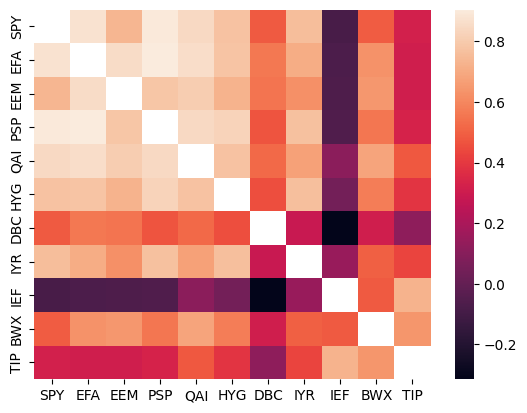

In [8]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. Furthermore, they have outperformed Domestic bonds in terms of mean and in terms of volatility.

Notably, TIPS have very low correlation to the other assets--including relatively low coorrelation to IEF (Domestic Bonds). In the correlation heat map above, we see that TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

## 2.3 The Tangency and the MV Frontier

In [9]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)
retsx_tan = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])

performanceMetrics(pd.concat([retsx,retsx_tan],axis=1),annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1451,0.1479,0.9814,-0.1290,0.1268
EFA,0.0838,0.1648,0.5085,-0.1452,0.1429
EEM,0.0650,0.1942,0.3345,-0.1791,0.1628
PSP,0.1344,0.2270,0.5920,-0.2789,0.2296
QAI,0.0194,0.0509,0.3803,-0.0605,0.0364
HYG,0.0629,0.0883,0.7125,-0.1044,0.1379
DBC,0.0219,0.1755,0.1247,-0.1776,0.1631
IYR,0.1227,0.1898,0.6467,-0.2005,0.2956
IEF,0.0112,0.0643,0.1750,-0.0476,0.0461
BWX,-0.0045,0.0854,-0.0531,-0.0694,0.0780


## Not Required - For Illustration

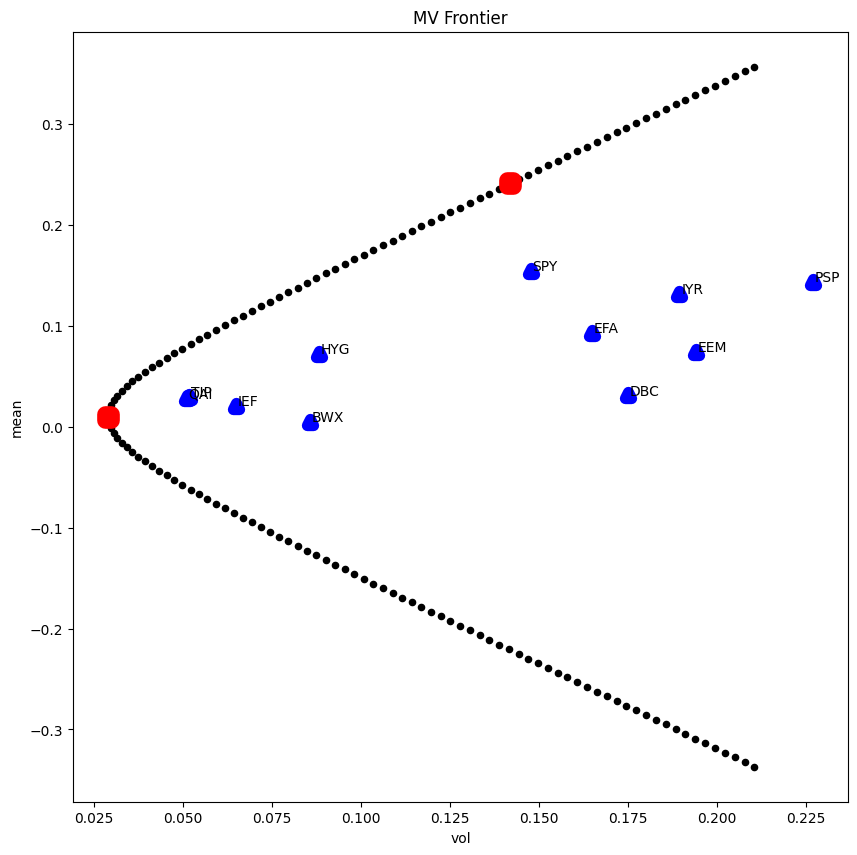

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    omega_tan = tangency_weights(rets)
    rets_adj = rets - rets.mean() + 1
    omega_gmv = tangency_weights(rets_adj)
    omega = pd.concat([omega_tan,omega_gmv],axis=1)
    omega.columns = ['tangency','gmv']
    
    delta_grid = np.linspace(-1.5,1.5,150)
    mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
    for i, delta in enumerate(delta_grid):
        omega_mv = delta * omega_tan + (1-delta) * omega_gmv
        rets_p = rets @ omega_mv
        mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
        mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
        
    rets_special = pd.DataFrame(index=rets.index)
    rets_special['tan'] = rets @ omega_tan.values
    rets_special['gmv'] = rets @ omega_gmv.values
    
    mv_assets = pd.concat([rets.mean() * 12,rets.std() * np.sqrt(12)],axis=1)
    mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
    mv_assets.columns = ['mean','vol']
    mv_special.columns = ['mean','vol']
    
    ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
    mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
    mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)

    for i in range(mv_assets.shape[0]):
        plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

### How similar are tangency to 0 (in total returns) and tangency to risk-free (excess returns)?

In [11]:
comp = pd.concat([wts['tangency'], omega['tangency']],axis=1)
comp.columns = ['tan.riskfree','tan.zero']
comp

print(f'Correlation between tangency weights in total and excess returns is {comp.corr().values[0,1]:.4f}.')

Correlation between tangency weights in total and excess returns is 0.9764.


## 2.4 The Allocation

In [12]:
target_mean = .0075

mu_tan = retsx.mean() @ wts['tangency']
delta = target_mean / mu_tan

wts['optimal'] = wts['tangency'] * delta

# list the assets sharpe ratios in a column to demonstrate not highly correlated with optimal weights
comp = pd.concat([wts[['optimal']],mets['Sharpe']],axis=1)
corr_sharpe_wts = comp.corr().values[0][1]

comp.sort_values('optimal',ascending=False)

,optimal,Sharpe
SPY,0.7139,0.9814
IEF,0.6430,0.1750
HYG,0.3549,0.7125
EEM,0.1023,0.3345
TIP,0.0557,0.3910
DBC,0.0174,0.1247
EFA,0.0052,0.5085
PSP,-0.1177,0.5920
IYR,-0.1263,0.6467
BWX,-0.4725,-0.0531


In [13]:
print(f'Total share in risky assets is {delta:.4f}.\nTotal share in risk-free asset is {1-delta:.4f}')
print(f'Correlation between an assets Sharpe ratio and its weight is {corr_sharpe_wts:.4f}.')

Total share in risky assets is 0.0102.
Total share in risk-free asset is 0.9898
Correlation between an assets Sharpe ratio and its weight is 0.3629.


## 2.5 Simple Portfolios

In [14]:
wts['equal'] = 1/len(retsx.columns)
wts['parity'] = 1/retsx.std()
# rescale these to hit the target mean
wts[['equal','parity']] *= target_mean / (retsx.mean()@wts[['equal','parity']])

wts

,tangency,optimal,equal,parity
SPY,69.9009,0.7139,0.1319,0.1270
EFA,0.5121,0.0052,0.1319,0.1139
EEM,10.0182,0.1023,0.1319,0.0967
PSP,-11.5283,-0.1177,0.1319,0.0827
QAI,-114.1310,-1.1656,0.1319,0.3686
HYG,34.7469,0.3549,0.1319,0.2127
DBC,1.7013,0.0174,0.1319,0.1070
IYR,-12.3661,-0.1263,0.1319,0.0989
IEF,62.9591,0.6430,0.1319,0.2920
BWX,-46.2642,-0.4725,0.1319,0.2199


In [15]:
mets_full = performanceMetrics(retsx @ wts,annualization=12)
mets_full

,Mean,Vol,Sharpe,Min,Max
tangency,8.8122,5.2934,1.6647,-3.6495,5.3751
optimal,0.0900,0.0541,1.6647,-0.0373,0.0549
equal,0.0900,0.1511,0.5958,-0.1700,0.1338
parity,0.0900,0.1550,0.5808,-0.1624,0.1132


## For Illustration, not Required

### Suppose TIPS had a mean return 1% (annualized) higher than in the sample

* Would the weights change much?
* Would the MV frontier change much?

In [16]:
retsx_adj = retsx.copy()
retsx_adj['TIP'] += .01/12

wts_adj = wts[['tangency','optimal']].copy()
wts_adj['tangency adj'] = tangency_weights(retsx_adj)
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'],columns=['tangency adj'])

mu_adj = retsx_adj.mean()
mu_tan_adj = mu_adj @ wts_adj['tangency adj']
delta_adj = target_mean / mu_tan

wts_adj['optimal adj'] = wts_adj['tangency adj'] * delta_adj

wts_adj

,tangency,optimal,tangency adj,optimal adj
SPY,69.9009,0.7139,9.5902,0.0979
EFA,0.5121,0.0052,0.5856,0.0060
EEM,10.0182,0.1023,1.3336,0.0136
PSP,-11.5283,-0.1177,-1.8304,-0.0187
QAI,-114.1310,-1.1656,-16.9381,-0.1730
HYG,34.7469,0.3549,4.9623,0.0507
DBC,1.7013,0.0174,-0.2008,-0.0021
IYR,-12.3661,-0.1263,-1.8779,-0.0192
IEF,62.9591,0.6430,5.1409,0.0525
BWX,-46.2642,-0.4725,-6.8546,-0.0700


In [17]:
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj','optimal adj']], annualization=12)
pd.concat([mets_full.loc[['tangency','optimal']],mets_adj])

,Mean,Vol,Sharpe,Min,Max
tangency,8.8122,5.2934,1.6647,-3.6495,5.3751
optimal,0.0900,0.0541,1.6647,-0.0373,0.0549
tangency adj,1.3340,0.7773,1.7161,-0.4939,0.8832
optimal adj,0.0136,0.0079,1.7161,-0.0050,0.0090


In [18]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.4f}')
print(f'Proposed adjustment to mean of TIPS is {.01/12 : 0.4f}')

Standard error of mean of TIPS is equal to 0.0011
Proposed adjustment to mean of TIPS is  0.0008


## 2.6 Out-of-Sample Testing

In [19]:
retsx_IS = retsx.loc[:'2020']
retsx_OOS = retsx.loc['2021':]
wts_IS = tangency_weights(retsx.loc[:'2020'])
wts_IS.columns = ['mv']

wts_IS['equal'] = 1/len(retsx_IS.columns)
wts_IS['parity'] = 1/retsx_IS.std()
# rescale these to hit the target mean
wts_IS *= target_mean / (retsx_IS.mean()@ wts_IS)

wts_IS

,mv,equal,parity
SPY,0.5891,0.1048,0.0911
EFA,-0.0571,0.1048,0.0782
EEM,0.0204,0.1048,0.0645
PSP,-0.0186,0.1048,0.0593
QAI,-0.8983,0.1048,0.2637
HYG,0.3461,0.1048,0.1465
DBC,-0.0531,0.1048,0.0729
IYR,-0.1568,0.1048,0.0705
IEF,0.6336,0.1048,0.2268
BWX,-0.0293,0.1048,0.1728


In [20]:
port_IS = retsx_IS @ wts_IS

performanceMetrics(port_IS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,0.0900,0.0393,2.2899,-0.0140,0.0490
equal,0.0900,0.1159,0.7769,-0.1350,0.1063
parity,0.0900,0.1009,0.8922,-0.1143,0.0782


In [21]:
port_OOS = retsx_OOS @ wts_IS

performanceMetrics(port_OOS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,0.0084,0.0856,0.0978,-0.0533,0.0623
equal,0.0079,0.1332,0.0590,-0.0946,0.0730
parity,-0.0252,0.1389,-0.1813,-0.1031,0.0748


### Why does the MV Portfolio do worse?
#### It has a huge position in SPY, and SPY was the best performing asset in 2021!

In [22]:
performanceMetrics(retsx_OOS,annualization=12).sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
DBC,0.1429,0.1660,0.8605,-0.0871,0.1014
SPY,0.1038,0.1682,0.6172,-0.0927,0.0912
EFA,0.0455,0.1648,0.2761,-0.0925,0.1283
PSP,0.0466,0.2568,0.1816,-0.1466,0.1784
IYR,0.0213,0.2105,0.1011,-0.1274,0.1179
HYG,-0.0060,0.0866,-0.0697,-0.0697,0.0661
QAI,-0.0123,0.0568,-0.2163,-0.0401,0.0364
EEM,-0.0475,0.1694,-0.2802,-0.1157,0.1525
TIP,-0.0328,0.0680,-0.4822,-0.0676,0.0422
IEF,-0.0761,0.0806,-0.9442,-0.0476,0.0405
